# Robustness to Outliers

Only one method, `robustdiff`, is designed intentionally to handle outliers. Here we plot its performance on simulations versus its closest cousin, `rtsdiff`. Both assume the same model and solve the Maximum A Priori (MAP) estimation problem (see Taxonomy paper), but whereas Rauch-Tung-Striebel optimizes an $\ell_2$ norm objective, the robust variant optimizes an $\ell_1$ norm or Huber loss objective. This relies on a convex solver and takes significantly longer to run but is indespensable, as shown by the outliers performance experiment in notebook 4 and examples here.

In [15]:
import numpy as np
from time import time

from pynumdiff.optimize import optimize
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous, pi_cruise_control, lorenz_x
from pynumdiff.kalman_smooth import robustdiff, rtsdiff
from pynumdiff.utils import evaluate

In [16]:
# Collected from a previous run
cache = {(rtsdiff, pi_cruise_control): {'qr_ratio': 1593.75, 'forwardbackward': True, 'order': 1},
		 (robustdiff, pi_cruise_control): {'qr_ratio': 41562500000.0, 'huberM': 36.046875, 'order': 3},
		 (rtsdiff, sine): {'qr_ratio': 89500000.0, 'forwardbackward': True, 'order': 3},
		 (robustdiff, sine): {'qr_ratio': 1375000.0, 'huberM': 8.953125, 'order': 2},
		 (rtsdiff, triangle): {'qr_ratio': 1465.625, 'forwardbackward': True, 'order': 1},
		 (robustdiff, triangle): {'qr_ratio': 981.25, 'huberM': 0.0001171875, 'order': 1},
		 (rtsdiff, pop_dyn): {'qr_ratio': 437.5, 'forwardbackward': False, 'order': 3},
		 (robustdiff, pop_dyn): {'qr_ratio': 997.265625, 'huberM': 6.591796875e-05, 'order': 2},
		 (rtsdiff, linear_autonomous): {'qr_ratio': 18062500.0, 'forwardbackward': False, 'order': 3},
		 (robustdiff, linear_autonomous): {'qr_ratio': 9375000.0, 'huberM': 0.75, 'order': 2},
		 (rtsdiff, lorenz_x): {'qr_ratio': 2500000.0, 'forwardbackward': True, 'order': 2},
		 (robustdiff, lorenz_x): {'qr_ratio': 14312500.0, 'huberM': 9.5, 'order': 2}}

Loop particular simulation examples, plotting comparative results against the data series. 

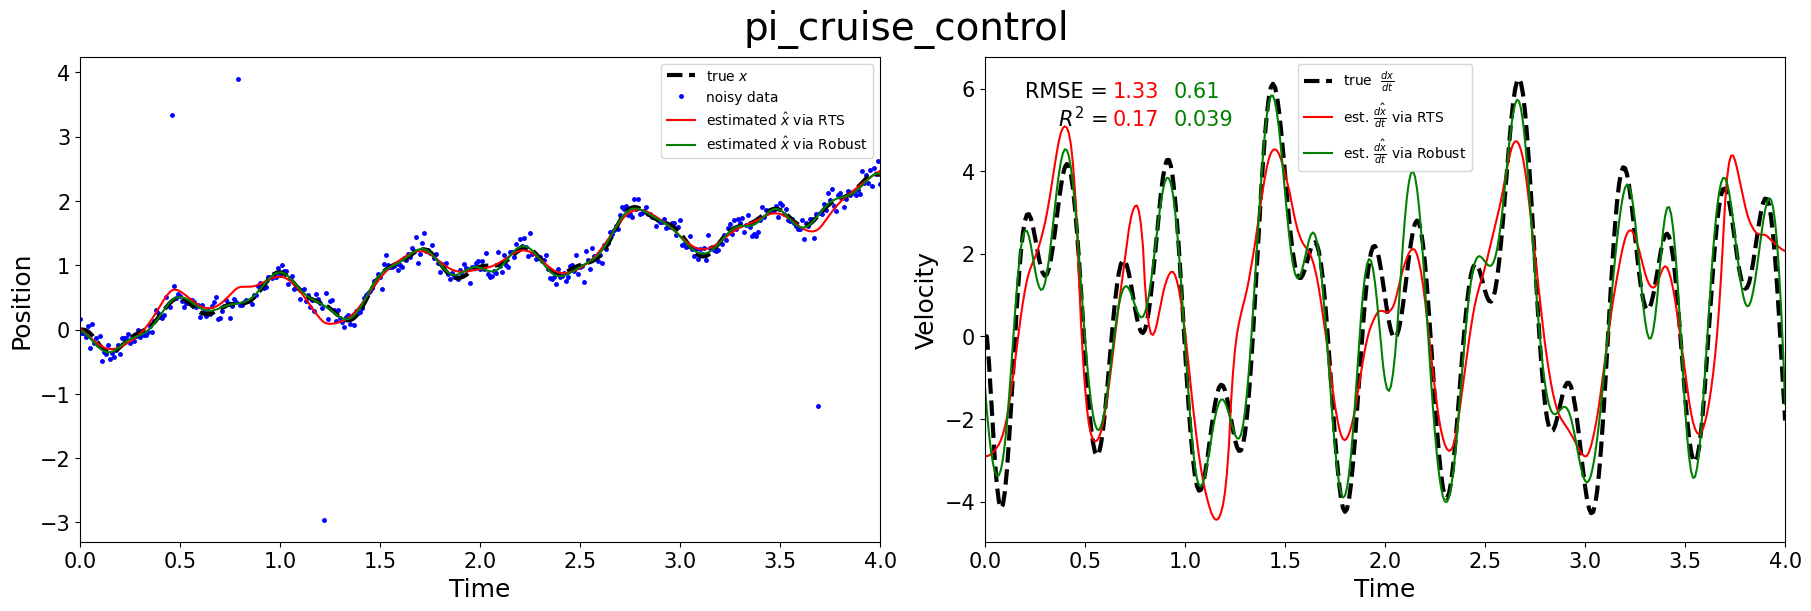

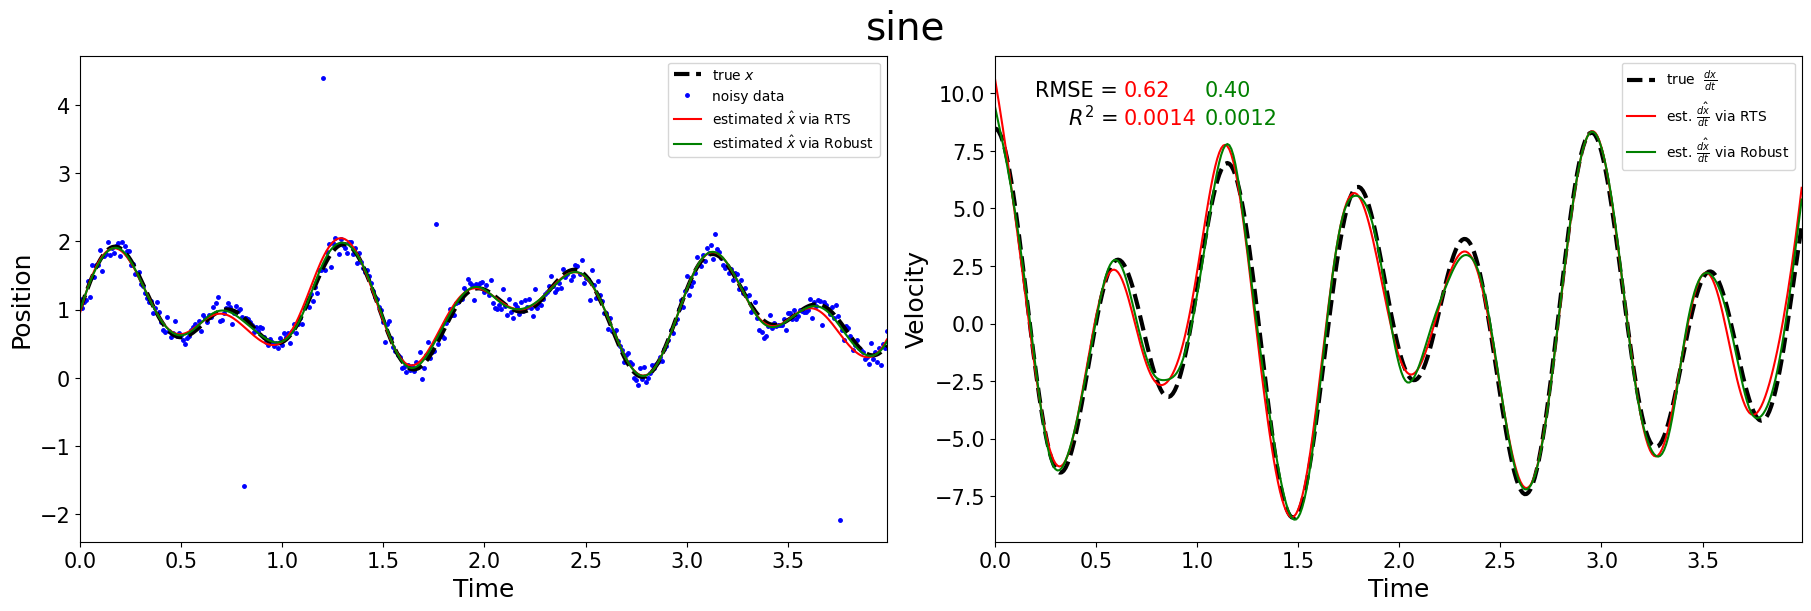

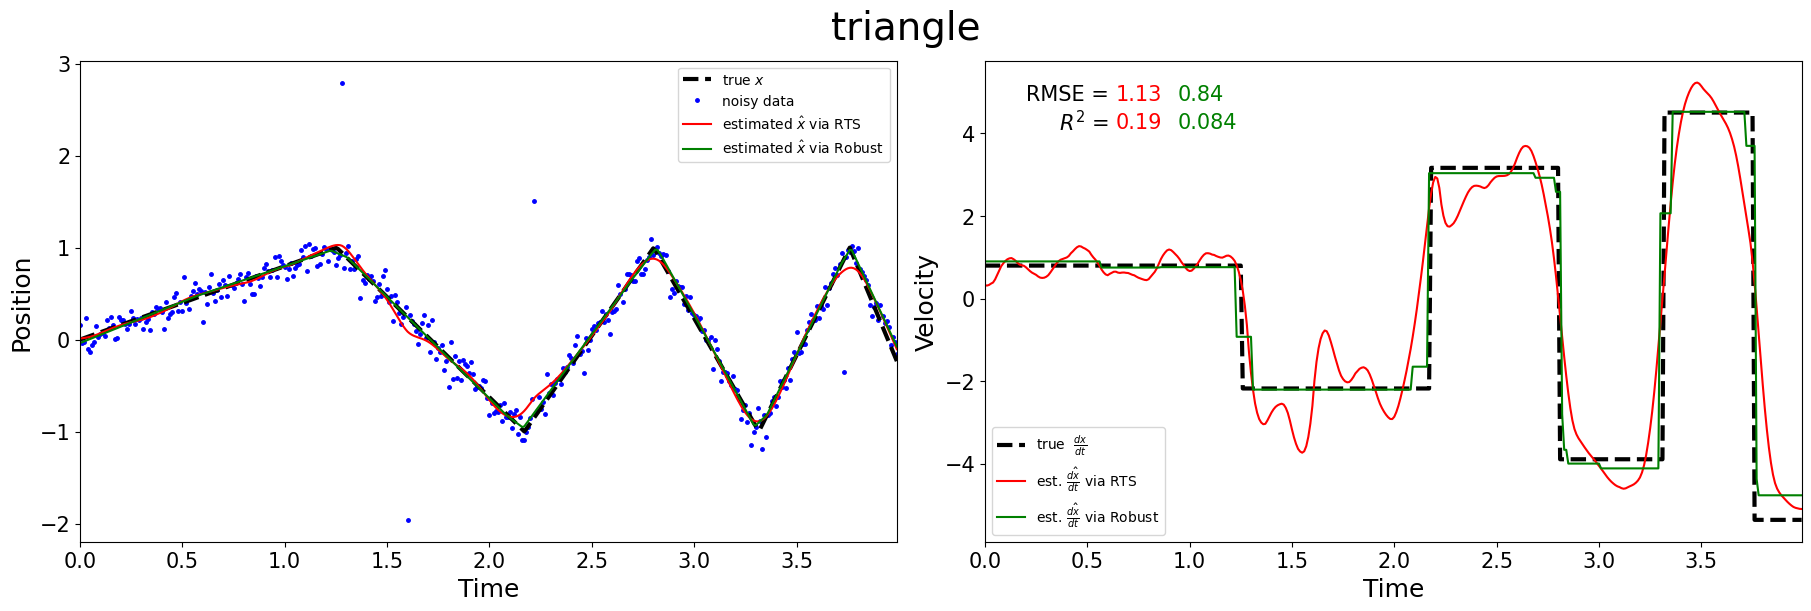

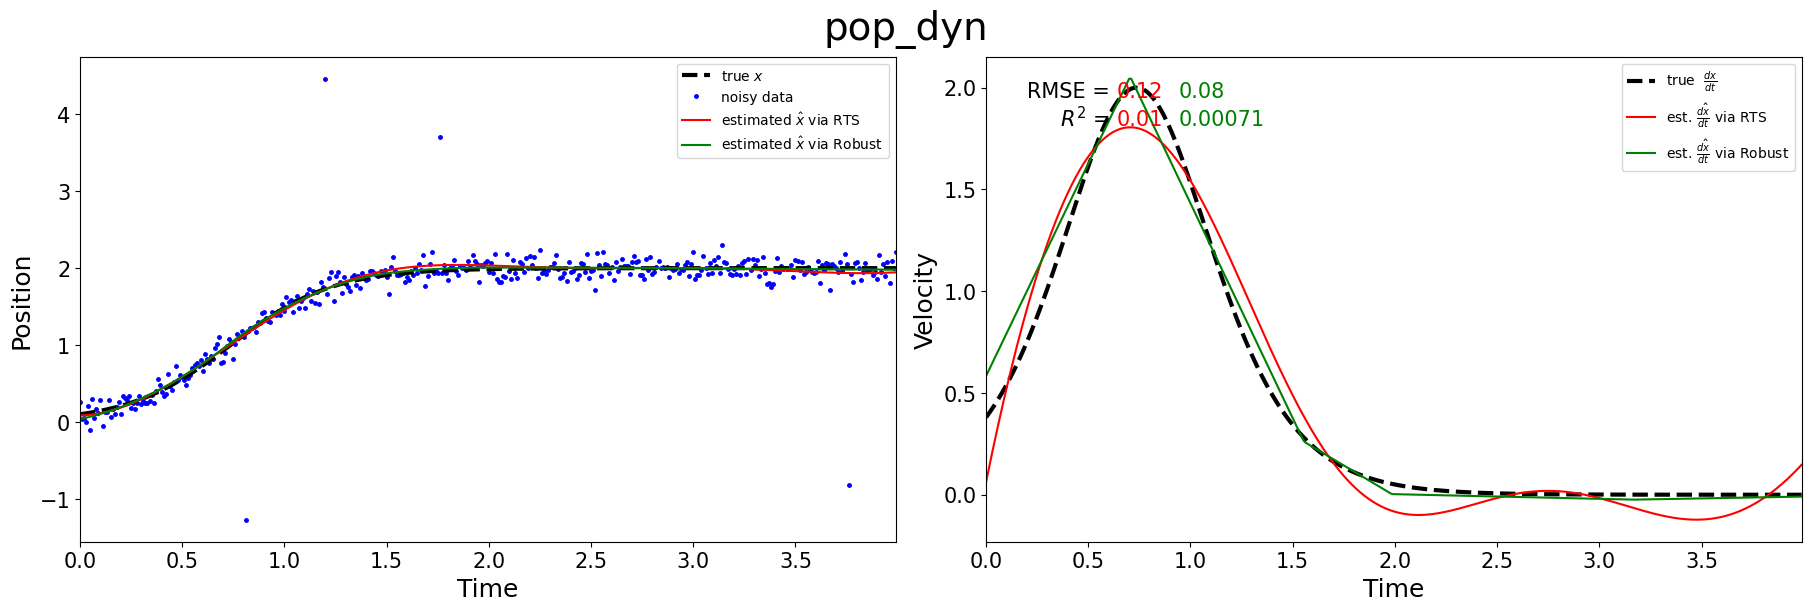

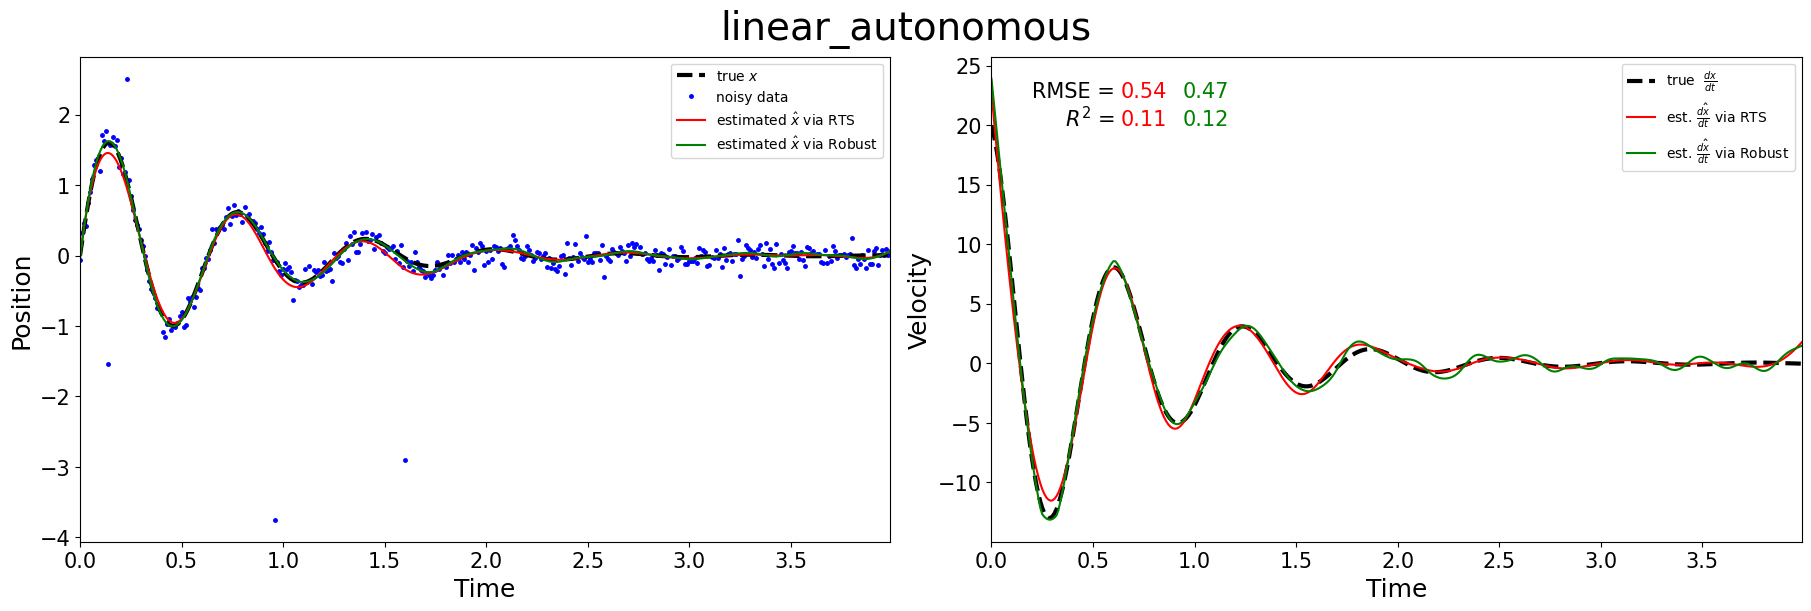

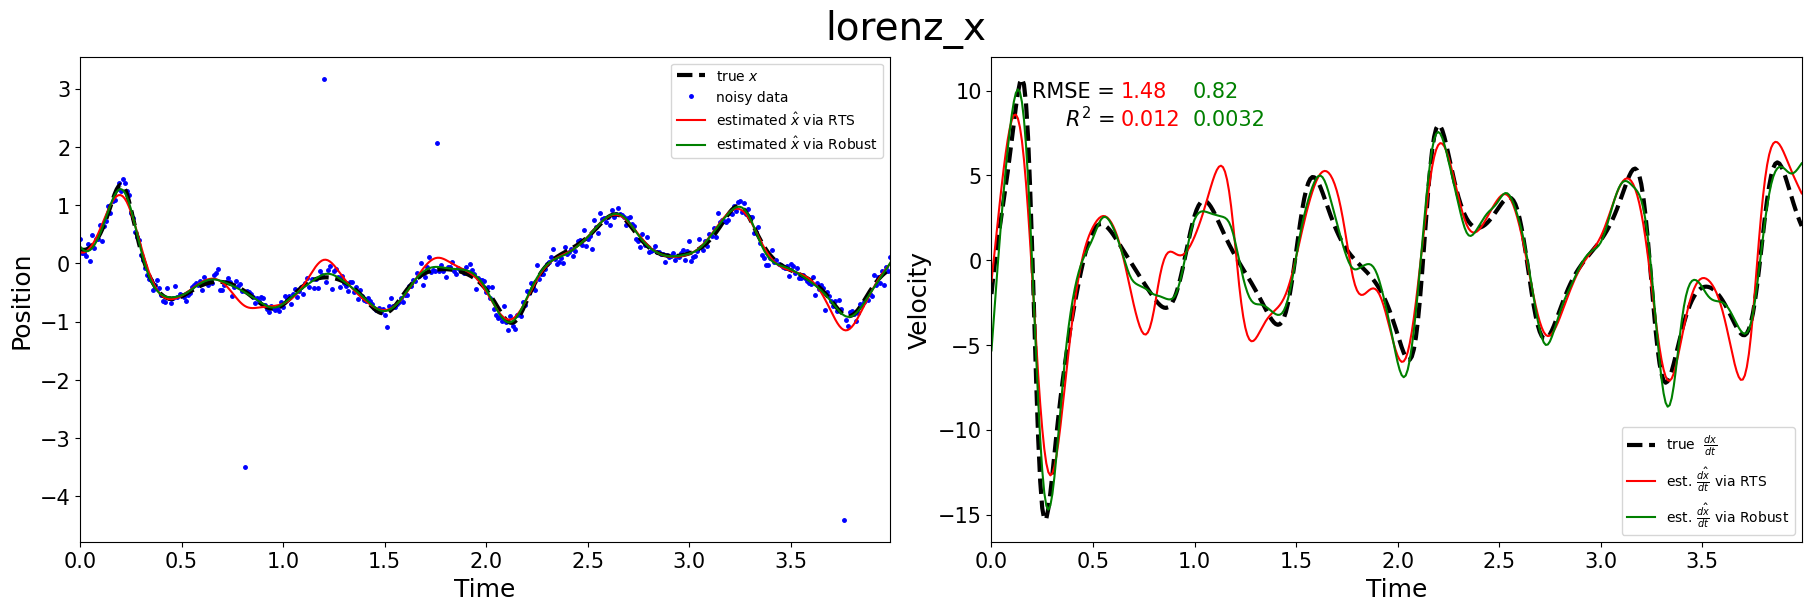

In [18]:
dt = 0.01
for problem in [pi_cruise_control, sine, triangle, pop_dyn, linear_autonomous, lorenz_x]:
	x, x_truth, dxdt_truth = problem(duration=4, noise_type='normal',
	                                noise_parameters=[0, 0.1], dt=dt, outliers=True)
	t = np.arange(0, dt*len(x), dt)

	for method in [rtsdiff, robustdiff]:
		if (method, problem) in cache:
			params = cache[(method, problem)]
		else:
			start = time()
			params, val = optimize(method, x, dt, dxdt_truth=dxdt_truth)
			print(f'Optimal parameters for {method.__name__} on {problem.__name__}: {params}, found in {time() - start:.2f} seconds')
		
		x_hat, dxdt_hat = method(x, dt, **params)
		_, _, rms_dxdt = evaluate.rmse(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)
		R_sqr = evaluate.error_correlation(dxdt_hat, dxdt_truth)
		
		if method == rtsdiff:
			fig, axes = evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth, show_error=False)
			axes[1].text(0.05, 0.95, f"RMSE =\n     $R^2$ =", # Show performance metrics for both methods manually
                transform=axes[1].transAxes, fontsize=15, color='black', verticalalignment='top')
			axes[1].text(0.16, 0.95, f"{rms_dxdt:.2f}\n{R_sqr:.2g}",
                transform=axes[1].transAxes, fontsize=15, color='red', verticalalignment='top', linespacing=1.5)
			w = len(f"{R_sqr:.2g}")
		else:
			axes[0].plot(t, x_hat, color='green', label=".") # need dummy labels here to generate more handles
			axes[1].plot(t, dxdt_hat, color='green', label=".")
			handles, labels = axes[0].get_legend_handles_labels() # need more specific labels, because adding more than usual
			axes[0].legend(handles, labels[:2] + [r"estimated $\hat{x}$ via RTS", r"estimated $\hat{x}$ via Robust"])
			handles, labels = axes[1].get_legend_handles_labels()
			axes[1].legend(handles, [labels[0], r"est. $\hat{\frac{dx}{dt}}$ via RTS", r"est. $\hat{\frac{dx}{dt}}$ via Robust"])
			axes[1].text(0.26 - 0.012*(6 - w), 0.95, f"{rms_dxdt:.2f}\n{R_sqr:.2g}",
                transform=axes[1].transAxes, fontsize=15, color='green', verticalalignment='top', linespacing=1.5)

	fig.suptitle(f"{problem.__name__}", fontsize=28)